


# Predicting Hotel Cancellations

In this project we are tasked with supporting a hotel by predicting the Cancelled/Not Cancelled Bookings based on the Data Set they have provided us.

They want us to create a model which has highest amount of Predicting power possible so that they can predict which bookings may get cancelled in advance and adjust their promotions and open the slots for booking so that mean occupancy rate does not get effected due to the Cancelled bookings.

While the problem itself is not completely Unsupervised its application can be done on the wide range of Unsupervised learning models when we have to find Classify the Booking Cancelled or not without labels. We will use the labels here to test also the unsupervised learning models.

In [1]:
import scipy as sp
import scipy.stats as stats
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import sklearn.model_selection

In [99]:
import itertools

def label_permute_compare(ytdf,yp,n=2):
    """
    ytdf: labels dataframe object
    yp: clustering label prediction output
    Returns permuted label order and accuracy. 
    Example output: (0,1) , 0.74 
    """
    
    perms = list(itertools.permutations(list(range(n))))
    acc = 0
    best_perm = 0
    labels = list(set(ytdf))
    
    
    for perm in perms:
        temp_labels = ytdf.replace(labels, perm).tolist()
        acc_lst = [temp_labels == yp]
        if np.mean(acc_lst) > acc:
            acc = np.mean(acc_lst)
            best_perm = perm
            
    return best_perm, acc

## The Data

They have provided us with their bookings data in a file called `hotel_bookings.csv`, which contains the following:

| Column     | Description              |
|------------|--------------------------|
| `Booking_ID` | Unique identifier of the booking. |
| `no_of_adults` | The number of adults. |
| `no_of_children` | The number of children. |
| `no_of_weekend_nights` | Number of weekend nights (Saturday or Sunday). |
| `no_of_week_nights` | Number of week nights (Monday to Friday). |
| `type_of_meal_plan` | Type of meal plan included in the booking. |
| `required_car_parking_space` | Whether a car parking space is required. |
| `room_type_reserved` | The type of room reserved. |
| `lead_time` | Number of days before the arrival date the booking was made. |
| `arrival_year` | Year of arrival. |
| `arrival_month` | Month of arrival. |
| `arrival_date` | Date of the month for arrival. |
| `market_segment_type` | How the booking was made. |
| `repeated_guest` | Whether the guest has previously stayed at the hotel. |
| `no_of_previous_cancellations` | Number of previous cancellations. |
| `no_of_previous_bookings_not_canceled` | Number of previous bookings that were canceled. |
| `avg_price_per_room` | Average price per day of the booking. |
| `no_of_special_requests` | Count of special requests made as part of the booking. |
| `booking_status` | Whether the booking was cancelled or not. |

Source (data has been modified): https://www.kaggle.com/datasets/ahsan81/hotel-reservations-classification-dataset

## Assignment has been broken into 5 Parts
1. Data Cleaning
2. EDA
3. Supervised Learning
4. Unsupervised Learning
4. Model Result Comparison and Summary

## Data Cleaning

Original Kaggle Dataset does not have any null value, however author of the dataset along with Datacamp randomly added Null values of the dataset and our working is done on the dirty dataset. I will provide the modified dataset in my Github and one can access the unmodified data set with no null values on the Kaggle.

In [2]:
df = pd.read_csv('hotel_bookings.csv')

In [3]:
df.head()

,Booking_ID,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,INN00001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Not_Canceled
1,INN00002,2.0,0.0,2.0,3.0,Not Selected,0.0,Room_Type 1,5.0,2018.0,11.0,6.0,Online,0.0,0.0,0.0,106.68,1.0,Not_Canceled
2,INN00003,1.0,0.0,2.0,1.0,Meal Plan 1,0.0,Room_Type 1,1.0,2018.0,2.0,28.0,Online,0.0,0.0,0.0,60.00,0.0,Canceled
3,INN00004,2.0,0.0,0.0,2.0,Meal Plan 1,0.0,Room_Type 1,211.0,2018.0,5.0,20.0,Online,0.0,0.0,0.0,100.00,0.0,Canceled
4,INN00005,2.0,0.0,1.0,1.0,Not Selected,0.0,Room_Type 1,48.0,2018.0,4.0,11.0,Online,0.0,0.0,0.0,94.50,0.0,Canceled


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36275 entries, 0 to 36274
Data columns (total 19 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Booking_ID                            36275 non-null  object 
 1   no_of_adults                          35862 non-null  float64
 2   no_of_children                        35951 non-null  float64
 3   no_of_weekend_nights                  35908 non-null  float64
 4   no_of_week_nights                     35468 non-null  float64
 5   type_of_meal_plan                     35749 non-null  object 
 6   required_car_parking_space            33683 non-null  float64
 7   room_type_reserved                    35104 non-null  object 
 8   lead_time                             35803 non-null  float64
 9   arrival_year                          35897 non-null  float64
 10  arrival_month                         35771 non-null  float64
 11  arrival_date   

Here in order to find the visible and hidden None Values while correcting the Data Types we need to through most of the columns. Due to which a lot of EDA has been done at this part.

In [5]:
cat_columns = [col for col in df.columns if df[col].dtype == 'object']
print(cat_columns)

['Booking_ID', 'type_of_meal_plan', 'room_type_reserved', 'market_segment_type', 'booking_status']


In [6]:
df['Booking_ID'].nunique()

36275

In [7]:
df['Booking_ID'].isnull().sum()

0

No problem with Booking_ID which is working as an index here.

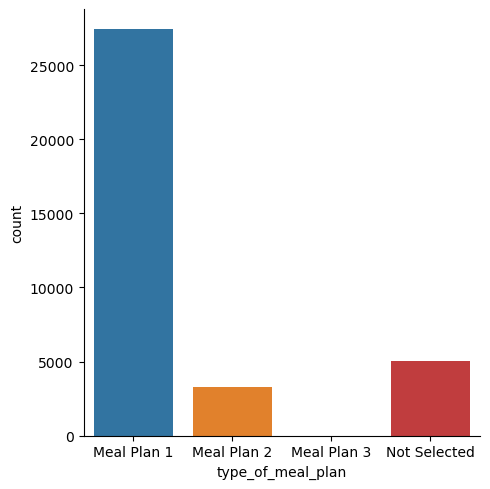

In [8]:
sns.catplot(data = df, x = 'type_of_meal_plan', kind = 'count', order = ['Meal Plan 1', 'Meal Plan 2', 'Meal Plan 3', 'Not Selected'])
plt.show()

In [10]:
df.loc[df['type_of_meal_plan'] == 'Meal Plan 3','type_of_meal_plan']

8558     Meal Plan 3
11922    Meal Plan 3
12423    Meal Plan 3
14914    Meal Plan 3
28594    Meal Plan 3
Name: type_of_meal_plan, dtype: object

In [9]:
df['type_of_meal_plan'].value_counts(normalize = True)

Meal Plan 1     0.767042
Not Selected    0.141459
Meal Plan 2     0.091359
Meal Plan 3     0.000140
Name: type_of_meal_plan, dtype: float64

In [11]:
df['type_of_meal_plan'].isna().sum()

526

Around 76% of the Mean Plans are the Mean Plan 1 and Mean Plan only have 5 entries due to which it was difficult to observe it in the plot. Moreover there are 526 Null Values in this column, we will once again visit these Null Values for all the Columns after the initial inspection.

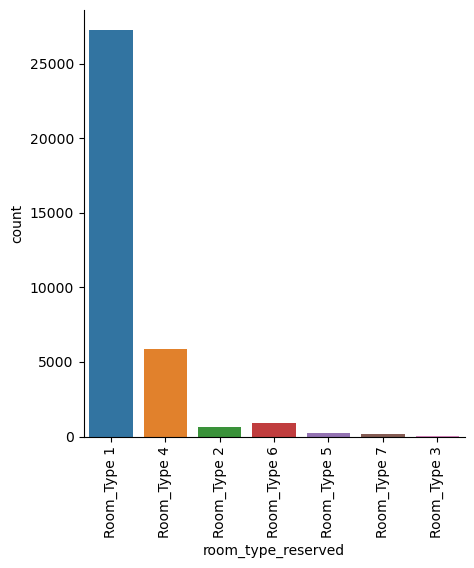

In [12]:
sns.catplot(data = df, x = 'room_type_reserved', kind = 'count')
plt.xticks(rotation = 90)
plt.show()

In [13]:
df['room_type_reserved'].value_counts(normalize = True)

Room_Type 1    0.775809
Room_Type 4    0.166676
Room_Type 6    0.026749
Room_Type 2    0.018915
Room_Type 5    0.007293
Room_Type 7    0.004387
Room_Type 3    0.000171
Name: room_type_reserved, dtype: float64

In [14]:
df['room_type_reserved'].isna().sum()

1171

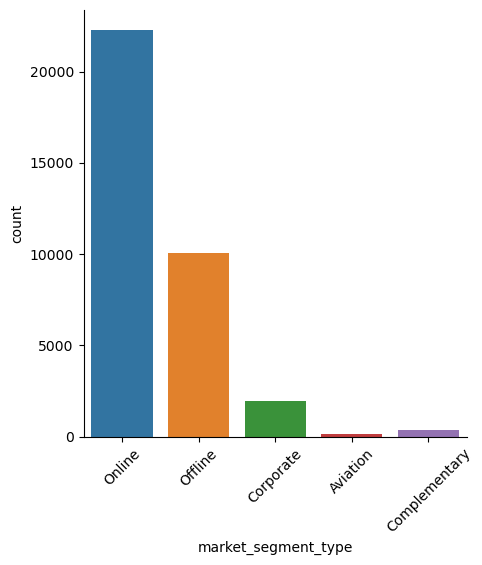

In [15]:
sns.catplot(data = df, x = 'market_segment_type', kind = 'count')
plt.xticks(rotation = 45)
plt.show()

In [16]:
df['market_segment_type'].value_counts(normalize = True)

Online           0.640451
Offline          0.289848
Corporate        0.055404
Complementary    0.010787
Aviation         0.003509
Name: market_segment_type, dtype: float64

In [17]:
df['market_segment_type'].isna().sum()

1512

In [18]:
df['booking_status'].value_counts()

Not_Canceled    24390
Canceled        11885
Name: booking_status, dtype: int64

In [19]:
df['booking_status'].isna().sum()

0

Now we have observed all the Categoriaal Variables besides the last one which is the response of the model. We will use it as Classification in the Supervised Learning and to compare the working of Unsupervised Learning model against the Test Response and Predicted.

In [20]:
num_columns = [col for col in df.columns if df[col].dtype == 'float64']
print(num_columns)

['no_of_adults', 'no_of_children', 'no_of_weekend_nights', 'no_of_week_nights', 'required_car_parking_space', 'lead_time', 'arrival_year', 'arrival_month', 'arrival_date', 'repeated_guest', 'no_of_previous_cancellations', 'no_of_previous_bookings_not_canceled', 'avg_price_per_room', 'no_of_special_requests']


In [21]:
df.describe()

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,required_car_parking_space,lead_time,arrival_year,arrival_month,arrival_date,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests
count,35862.000000,35951.000000,35908.000000,35468.00000,33683.000000,35803.000000,35897.000000,35771.000000,35294.000000,35689.000000,35778.000000,35725.000000,35815.000000,35486.000000
mean,1.845017,0.105366,0.810209,2.20331,0.030698,85.276569,2017.820431,7.424031,15.605712,0.025666,0.023646,0.154458,103.418207,0.619343
std,0.518652,0.402871,0.870857,1.40989,0.172501,85.998845,0.383834,3.068277,8.743484,0.158140,0.370835,1.764805,35.057342,0.785849
min,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,2017.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,0.000000,1.00000,0.000000,17.000000,2018.000000,5.000000,8.000000,0.000000,0.000000,0.000000,80.300000,0.000000
50%,2.000000,0.000000,1.000000,2.00000,0.000000,57.000000,2018.000000,8.000000,16.000000,0.000000,0.000000,0.000000,99.450000,0.000000
75%,2.000000,0.000000,2.000000,3.00000,0.000000,126.000000,2018.000000,10.000000,23.000000,0.000000,0.000000,0.000000,120.000000,1.000000
max,4.000000,10.000000,7.000000,17.00000,1.000000,443.000000,2018.000000,12.000000,31.000000,1.000000,13.000000,58.000000,540.000000,5.000000


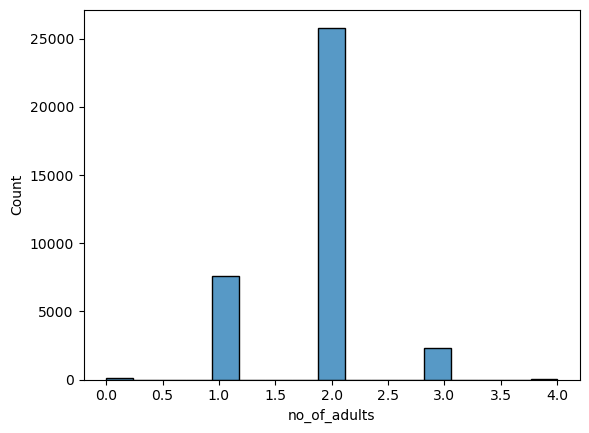

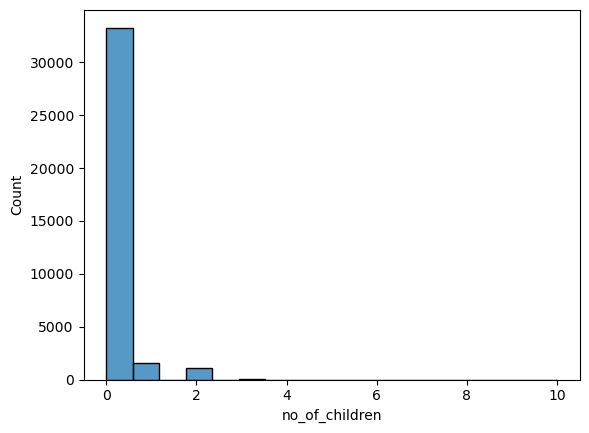

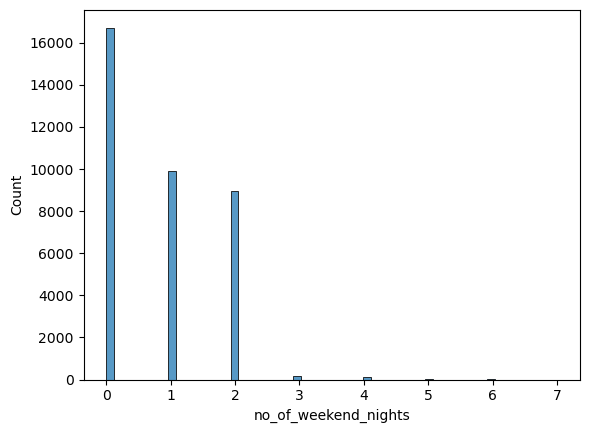

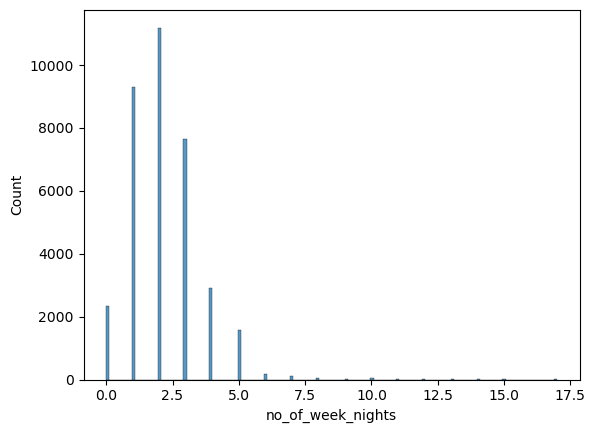

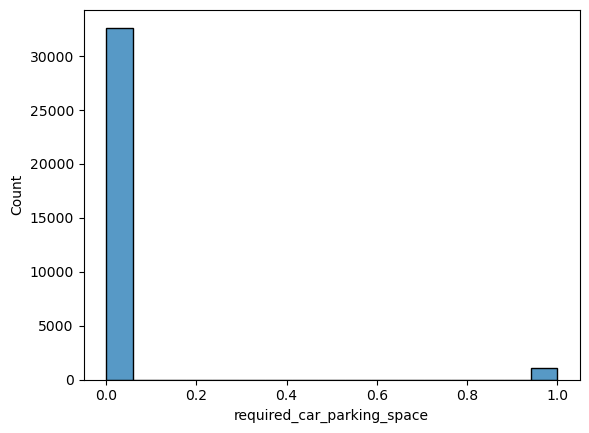

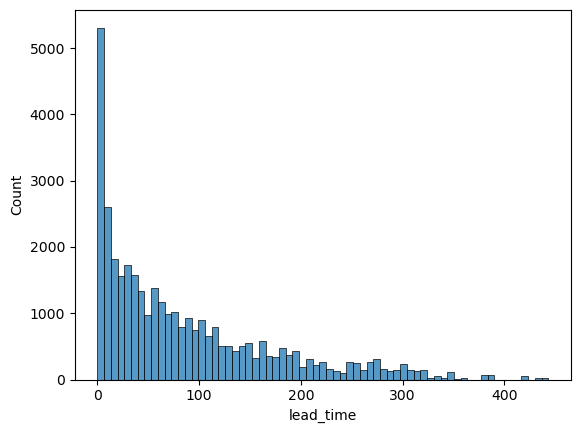

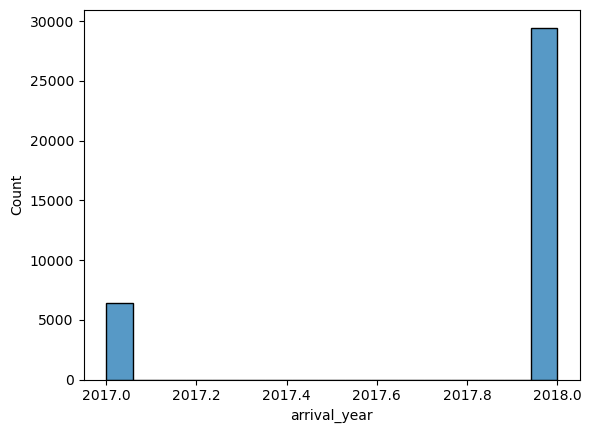

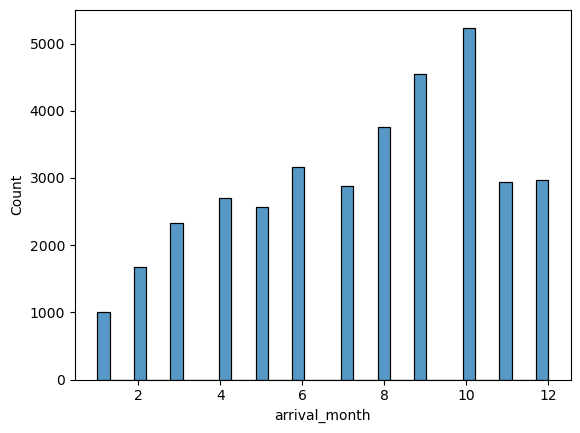

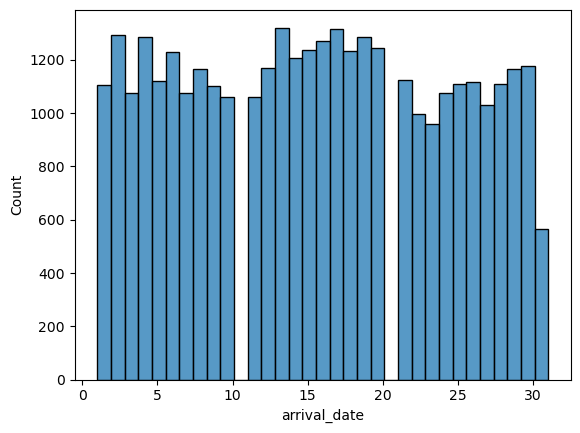

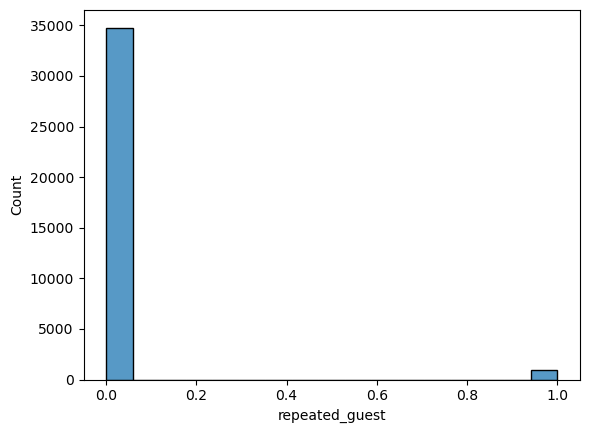

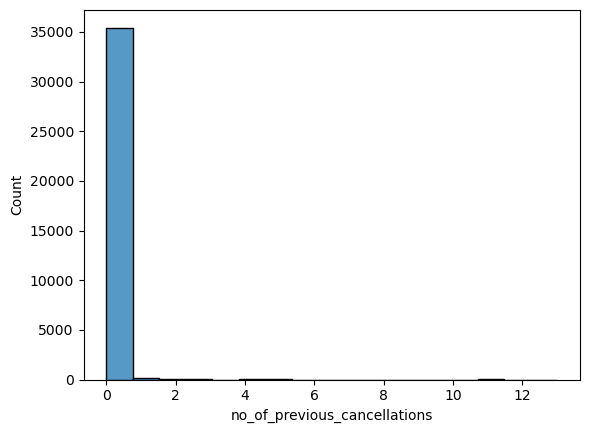

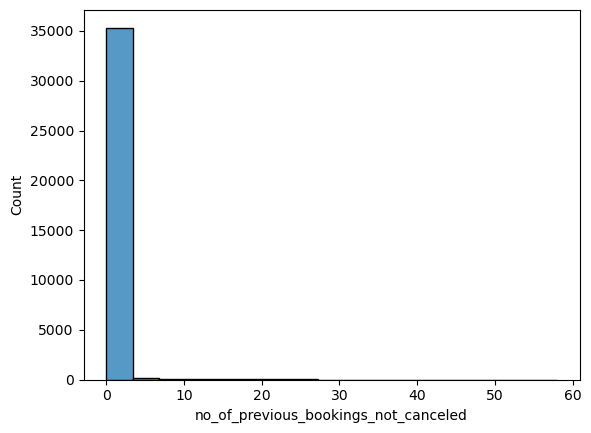

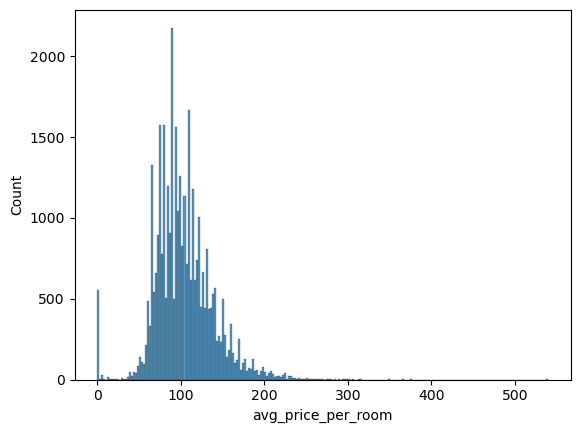

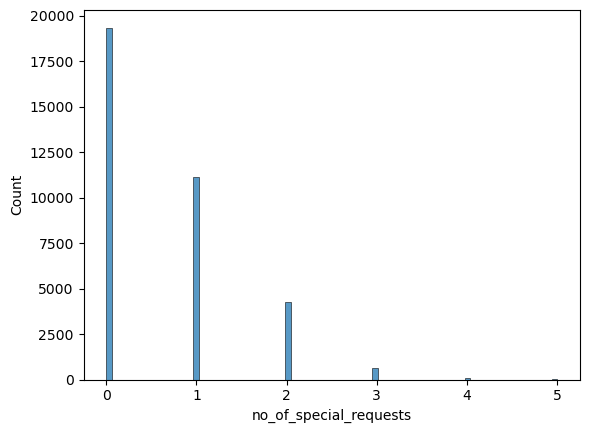

In [22]:
for col in num_columns:
    sns.histplot(data = df, x = col)
    plt.show()

From the preliminary observation of the Numeric Variables we can see that a few of the Columns need to be changed in proper Data Types to reflect the data they contain. We will adjust the Date columns so that they don't appear as floats and give values like 2017.2 for the year. 

We will also have to correct the columns like repeated_guests, number of adults, children, and required parking space as they can be converted into Categorial Variables instead of the Numeric so that we don't get values like 2.5 Adults and so on for our Models. 

In [23]:
df[['arrival_year', 'arrival_month', 'arrival_date']]

,arrival_year,arrival_month,arrival_date
0,NaN,NaN,NaN
1,2018.0,11.0,6.0
2,2018.0,2.0,28.0
3,2018.0,5.0,20.0
4,2018.0,4.0,11.0
...,...,...,...
36270,2018.0,8.0,3.0
36271,2018.0,10.0,17.0
36272,2018.0,7.0,1.0
36273,2018.0,4.0,21.0


In [24]:
df['arrival_year'] = df['arrival_year'].astype('Int64') 
df['arrival_month'] = df['arrival_month'].astype('Int64') 
df['arrival_date'] = df['arrival_date'].astype('Int64') 

In [25]:
df.head()

,Booking_ID,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,INN00001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,Not_Canceled
1,INN00002,2.0,0.0,2.0,3.0,Not Selected,0.0,Room_Type 1,5.0,2018,11,6,Online,0.0,0.0,0.0,106.68,1.0,Not_Canceled
2,INN00003,1.0,0.0,2.0,1.0,Meal Plan 1,0.0,Room_Type 1,1.0,2018,2,28,Online,0.0,0.0,0.0,60.00,0.0,Canceled
3,INN00004,2.0,0.0,0.0,2.0,Meal Plan 1,0.0,Room_Type 1,211.0,2018,5,20,Online,0.0,0.0,0.0,100.00,0.0,Canceled
4,INN00005,2.0,0.0,1.0,1.0,Not Selected,0.0,Room_Type 1,48.0,2018,4,11,Online,0.0,0.0,0.0,94.50,0.0,Canceled


In [26]:
df['no_of_adults'] = df['no_of_adults'].astype('Int64')
df['no_of_children'] = df['no_of_children'].astype('Int64')
df['no_of_weekend_nights'] = df['no_of_weekend_nights'].astype('Int64')
df['required_car_parking_space'] = df['required_car_parking_space'].astype('Int64')
df['repeated_guest'] = df['repeated_guest'].astype('Int64')
df['no_of_week_nights'] = df['no_of_weekend_nights'].astype('Int64')
df['no_of_previous_cancellations'] = df['no_of_previous_cancellations'].astype('Int64')
df['no_of_previous_bookings_not_canceled'] = df['no_of_previous_bookings_not_canceled'].astype('Int64')
df['no_of_special_requests'] = df['no_of_special_requests'].astype('Int64')

In [27]:
df.dtypes

Booking_ID                               object
no_of_adults                              Int64
no_of_children                            Int64
no_of_weekend_nights                      Int64
no_of_week_nights                         Int64
type_of_meal_plan                        object
required_car_parking_space                Int64
room_type_reserved                       object
lead_time                               float64
arrival_year                              Int64
arrival_month                             Int64
arrival_date                              Int64
market_segment_type                      object
repeated_guest                            Int64
no_of_previous_cancellations              Int64
no_of_previous_bookings_not_canceled      Int64
avg_price_per_room                      float64
no_of_special_requests                    Int64
booking_status                           object
dtype: object

In [28]:
df.describe()

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,required_car_parking_space,lead_time,arrival_year,arrival_month,arrival_date,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests
count,35862.000000,35951.000000,35908.000000,35908.000000,33683.000000,35803.000000,35897.000000,35771.000000,35294.000000,35689.000000,35778.000000,35725.000000,35815.000000,35486.000000
mean,1.845017,0.105366,0.810209,0.810209,0.030698,85.276569,2017.820431,7.424031,15.605712,0.025666,0.023646,0.154458,103.418207,0.619343
std,0.518652,0.402871,0.870857,0.870857,0.172501,85.998845,0.383834,3.068277,8.743484,0.158140,0.370835,1.764805,35.057342,0.785849
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2017.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,0.000000,0.000000,0.000000,17.000000,2018.000000,5.000000,8.000000,0.000000,0.000000,0.000000,80.300000,0.000000
50%,2.000000,0.000000,1.000000,1.000000,0.000000,57.000000,2018.000000,8.000000,16.000000,0.000000,0.000000,0.000000,99.450000,0.000000
75%,2.000000,0.000000,2.000000,2.000000,0.000000,126.000000,2018.000000,10.000000,23.000000,0.000000,0.000000,0.000000,120.000000,1.000000
max,4.000000,10.000000,7.000000,7.000000,1.000000,443.000000,2018.000000,12.000000,31.000000,1.000000,13.000000,58.000000,540.000000,5.000000


Now we have labelled the Data Types properly for our analysis we will remove or impute the NA Values as required, after which we will perform the further analysis on the Cleaned Tidy Data.

In [29]:
df.isna().sum()

Booking_ID                                 0
no_of_adults                             413
no_of_children                           324
no_of_weekend_nights                     367
no_of_week_nights                        367
type_of_meal_plan                        526
required_car_parking_space              2592
room_type_reserved                      1171
lead_time                                472
arrival_year                             378
arrival_month                            504
arrival_date                             981
market_segment_type                     1512
repeated_guest                           586
no_of_previous_cancellations             497
no_of_previous_bookings_not_canceled     550
avg_price_per_room                       460
no_of_special_requests                   789
booking_status                             0
dtype: int64

Python only captures None or np.nan values. We will expand our search for other possible types of NA Values.

In [30]:
a = [np.nan, df['no_of_adults'][0], None, [], {}, 'NaN', 'Null','NULL','None','NA','?','-', '.','', ' ', '   ']
nulldemo = pd.DataFrame(a)

In [31]:
for col in df.columns:
    print(col, df[col].isin(a).sum())

Booking_ID 0
no_of_adults 413
no_of_children 324
no_of_weekend_nights 367
no_of_week_nights 367
type_of_meal_plan 526
required_car_parking_space 2592
room_type_reserved 1171
lead_time 472
arrival_year 378
arrival_month 504
arrival_date 981
market_segment_type 1512
repeated_guest 586
no_of_previous_cancellations 497
no_of_previous_bookings_not_canceled 550
avg_price_per_room 460
no_of_special_requests 789
booking_status 0


We will remove the Predictors which have more than 5% observations as Null Value and for the others, we will impute the value with Mean, Median, and Mode as required.

In [32]:
na_threshold = df.shape[0]*0.05

In [36]:
cols_impute = [col for col in df.columns if df[col].isna().sum() <= na_threshold]
cols_impute = cols_impute[1:-1] #Removing the Id and Response Column
print(len(cols_impute), cols_impute)

16 ['no_of_adults', 'no_of_children', 'no_of_weekend_nights', 'no_of_week_nights', 'type_of_meal_plan', 'room_type_reserved', 'lead_time', 'arrival_year', 'arrival_month', 'arrival_date', 'market_segment_type', 'repeated_guest', 'no_of_previous_cancellations', 'no_of_previous_bookings_not_canceled', 'avg_price_per_room', 'no_of_special_requests']


In [37]:
cols_drop = [col for col in df.columns if df[col].isna().sum() > na_threshold]
print(len(cols_drop), cols_drop)

1 ['required_car_parking_space']


In [38]:
df.shape

(36275, 19)

In [39]:
df['required_car_parking_space'].value_counts(normalize = True) 

0    0.969302
1    0.030698
Name: required_car_parking_space, dtype: Float64

While we can decide to drop required car_parking_space we can also use the mode for imputing it has around 32649 observations or around 97% of the recorded observations have 0 as value. For this assignment we will remove the rows with NA associated with required car_parking_space as we have more than 36000 observations. It should be noted that if the rows with these NAs were of higher proportion we would have removed the column.

In [40]:
df[df.columns[df.columns.isin(cols_impute)]].dtypes #The columns to impute

no_of_adults                              Int64
no_of_children                            Int64
no_of_weekend_nights                      Int64
no_of_week_nights                         Int64
type_of_meal_plan                        object
room_type_reserved                       object
lead_time                               float64
arrival_year                              Int64
arrival_month                             Int64
arrival_date                              Int64
market_segment_type                      object
repeated_guest                            Int64
no_of_previous_cancellations              Int64
no_of_previous_bookings_not_canceled      Int64
avg_price_per_room                      float64
no_of_special_requests                    Int64
dtype: object

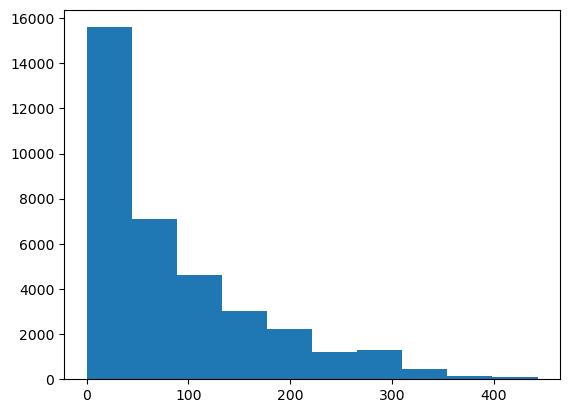

In [41]:
plt.hist(df['lead_time'])
plt.show()

In [42]:
df.corr()

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,required_car_parking_space,lead_time,arrival_year,arrival_month,arrival_date,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests
no_of_adults,1.000000,-0.019126,0.103320,0.103320,0.013670,0.096972,0.077463,0.021059,0.025936,-0.192710,-0.047553,-0.119408,0.295167,0.189116
no_of_children,-0.019126,1.000000,0.028860,0.028860,0.033771,-0.047373,0.045608,-0.004039,0.025120,-0.036214,-0.016495,-0.021113,0.335875,0.123200
no_of_weekend_nights,0.103320,0.028860,1.000000,1.000000,-0.030188,0.046520,0.055047,-0.011030,0.027480,-0.067965,-0.020368,-0.026315,-0.003804,0.060930
no_of_week_nights,0.103320,0.028860,1.000000,1.000000,-0.030188,0.046520,0.055047,-0.011030,0.027480,-0.067965,-0.020368,-0.026315,-0.003804,0.060930
required_car_parking_space,0.013670,0.033771,-0.030188,-0.030188,1.000000,-0.064788,0.016834,-0.018694,0.001429,0.103924,0.025754,0.060684,0.062835,0.088615
lead_time,0.096972,-0.047373,0.046520,0.046520,-0.064788,1.000000,0.144081,0.136039,0.006089,-0.136083,-0.046064,-0.078170,-0.062455,-0.100870
arrival_year,0.077463,0.045608,0.055047,0.055047,0.016834,0.144081,1.000000,-0.339571,0.018652,-0.018660,0.003819,0.026612,0.180072,0.052455
arrival_month,0.021059,-0.004039,-0.011030,-0.011030,-0.018694,0.136039,-0.339571,1.000000,-0.040890,0.001000,-0.038571,-0.009566,0.054624,0.111015
arrival_date,0.025936,0.025120,0.027480,0.027480,0.001429,0.006089,0.018652,-0.040890,1.000000,-0.017217,-0.012740,-0.001434,0.018460,0.019855
repeated_guest,-0.192710,-0.036214,-0.067965,-0.067965,0.103924,-0.136083,-0.018660,0.001000,-0.017217,1.000000,0.390566,0.538771,-0.175630,-0.012762


From the above we can see that the Lead Time is not correlated with other numerical values so we can't impute the missing values by groups and will collectively fill NAs with the median value. We will perform similar type of operation on other columns and determine best way of imputing.

In [43]:
df['lead_time'] = df['lead_time'].fillna(df['lead_time'].median())

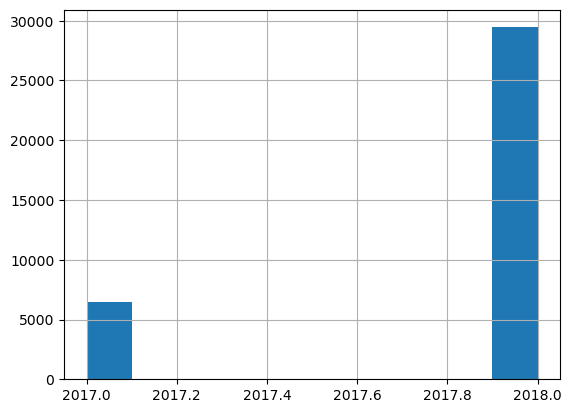

In [44]:
df['arrival_year'].hist()
plt.show()

In [45]:
df['arrival_year'] = df['arrival_year'].fillna(df['arrival_year'].mode()[0])

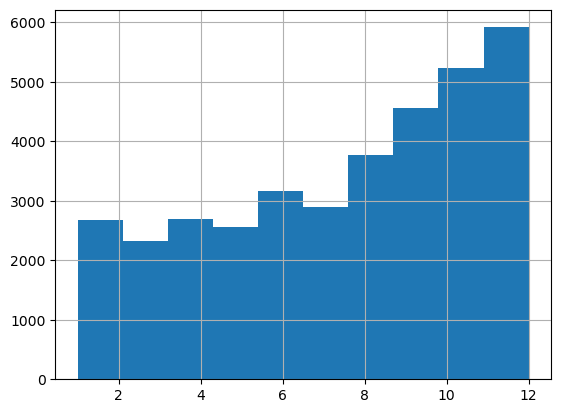

In [46]:
df['arrival_month'].hist()
plt.show()

In [47]:
df['arrival_month'] = df['arrival_month'].fillna(df['arrival_month'].median())

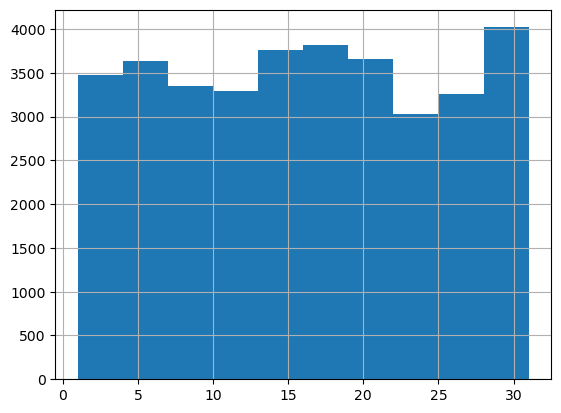

In [48]:
df['arrival_date'].hist()
plt.show()

In [49]:
df['arrival_date'] = df['arrival_date'].fillna(df['arrival_date'].median())

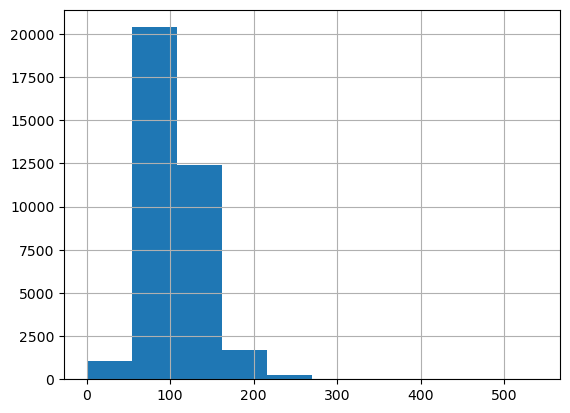

In [50]:
df['avg_price_per_room'].hist()
plt.show()                    

In [51]:
df['avg_price_per_room'] = df['avg_price_per_room'].fillna(df['avg_price_per_room'].median())

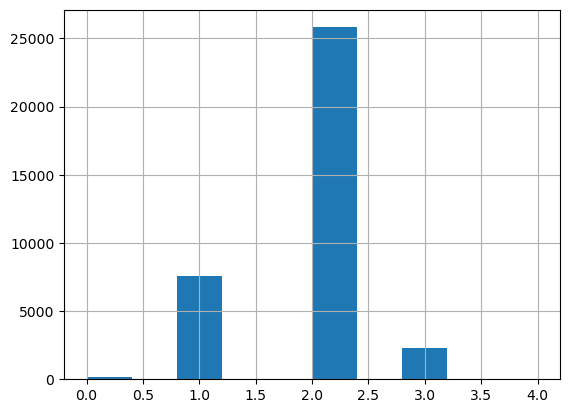

In [52]:
df['no_of_adults'].hist()
plt.show()

All the Columns with datatype of Int64 are essentially categorial variables and most of them have skewed dataframe, now we will impute the NAs of all of them with mode. The remaining ones like 'repeated_guest' column have some high correlation with others, we will aim to impute them using the grouped statistic.

In [53]:
for col in ['no_of_adults', 'no_of_children', 'no_of_weekend_nights', 'no_of_week_nights', 'no_of_special_requests']:
    df[col] = df[col].fillna(df[col].mode()[0]) 

In [54]:
impute_object = [col for col in df.columns[df.columns.isin(cols_impute)] if df[col].dtypes == 'object']
print(impute_object)

['type_of_meal_plan', 'room_type_reserved', 'market_segment_type']


In [55]:
for col in impute_object:
    df[col] = df[col].fillna(df[col].mode()[0]) 

In [56]:
df.isna().sum()

Booking_ID                                 0
no_of_adults                               0
no_of_children                             0
no_of_weekend_nights                       0
no_of_week_nights                          0
type_of_meal_plan                          0
required_car_parking_space              2592
room_type_reserved                         0
lead_time                                  0
arrival_year                               0
arrival_month                              0
arrival_date                               0
market_segment_type                        0
repeated_guest                           586
no_of_previous_cancellations             497
no_of_previous_bookings_not_canceled     550
avg_price_per_room                         0
no_of_special_requests                     0
booking_status                             0
dtype: int64

In [57]:
high_corr = ['repeated_guest','no_of_previous_cancellations','no_of_previous_bookings_not_canceled']

In [58]:
df['repeated_guest'] = df['repeated_guest'].fillna(df['no_of_previous_bookings_not_canceled'].map(df.groupby('no_of_previous_bookings_not_canceled')['repeated_guest'].median().to_dict()))
df['repeated_guest'] = df['repeated_guest'].fillna(df['repeated_guest'].mode()[0])

In [59]:
df['no_of_previous_bookings_not_canceled'] = df['no_of_previous_bookings_not_canceled'].fillna(df['repeated_guest'].map(df.groupby('repeated_guest')['no_of_previous_bookings_not_canceled'].median().to_dict()))
df['no_of_previous_bookings_not_canceled'] = df['no_of_previous_bookings_not_canceled'].fillna(df['no_of_previous_bookings_not_canceled'].mode()[0])

In [60]:
df['no_of_previous_cancellations'] = df['no_of_previous_cancellations'].fillna(df['no_of_previous_bookings_not_canceled'].map(df.groupby('no_of_previous_bookings_not_canceled')['no_of_previous_cancellations'].median().to_dict()))
df['no_of_previous_cancellations'] = df['no_of_previous_cancellations'].fillna(df['no_of_previous_cancellations'].mode()[0])

In [61]:
df.isna().sum()

Booking_ID                                 0
no_of_adults                               0
no_of_children                             0
no_of_weekend_nights                       0
no_of_week_nights                          0
type_of_meal_plan                          0
required_car_parking_space              2592
room_type_reserved                         0
lead_time                                  0
arrival_year                               0
arrival_month                              0
arrival_date                               0
market_segment_type                        0
repeated_guest                             0
no_of_previous_cancellations               0
no_of_previous_bookings_not_canceled       0
avg_price_per_room                         0
no_of_special_requests                     0
booking_status                             0
dtype: int64

In [62]:
df = df.drop(columns = 'required_car_parking_space')

In [63]:
df.isna().sum()

Booking_ID                              0
no_of_adults                            0
no_of_children                          0
no_of_weekend_nights                    0
no_of_week_nights                       0
type_of_meal_plan                       0
room_type_reserved                      0
lead_time                               0
arrival_year                            0
arrival_month                           0
arrival_date                            0
market_segment_type                     0
repeated_guest                          0
no_of_previous_cancellations            0
no_of_previous_bookings_not_canceled    0
avg_price_per_room                      0
no_of_special_requests                  0
booking_status                          0
dtype: int64

In [64]:
df.dtypes

Booking_ID                               object
no_of_adults                              Int64
no_of_children                            Int64
no_of_weekend_nights                      Int64
no_of_week_nights                         Int64
type_of_meal_plan                        object
room_type_reserved                       object
lead_time                               float64
arrival_year                              Int64
arrival_month                             Int64
arrival_date                              Int64
market_segment_type                      object
repeated_guest                            Int64
no_of_previous_cancellations              Int64
no_of_previous_bookings_not_canceled      Int64
avg_price_per_room                      float64
no_of_special_requests                    Int64
booking_status                           object
dtype: object

Now, we have a clean data with No Null values and correct Data Types for all the predictors. We are ready for further EDA and modeling.

## EDA

Most of the EDA has been done during the cleaning proces. We will further do some additional Exploration in this part.

In [104]:
df.describe()

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,lead_time,arrival_year,arrival_month,arrival_date,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests
count,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000
mean,1.846782,0.104425,0.802012,0.802012,84.908642,2017.822302,7.432033,15.616375,0.025582,0.023322,0.153025,103.367887,0.605872
std,0.515953,0.401191,0.870226,0.870226,85.497574,0.382264,3.047632,8.624680,0.157888,0.368296,1.752176,34.837177,0.782489
min,0.000000,0.000000,0.000000,0.000000,0.000000,2017.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,0.000000,0.000000,17.000000,2018.000000,5.000000,8.000000,0.000000,0.000000,0.000000,80.750000,0.000000
50%,2.000000,0.000000,1.000000,1.000000,57.000000,2018.000000,8.000000,16.000000,0.000000,0.000000,0.000000,99.450000,0.000000
75%,2.000000,0.000000,2.000000,2.000000,125.000000,2018.000000,10.000000,23.000000,0.000000,0.000000,0.000000,120.000000,1.000000
max,4.000000,10.000000,7.000000,7.000000,443.000000,2018.000000,12.000000,31.000000,1.000000,13.000000,58.000000,540.000000,5.000000


In [65]:
df.head()

,Booking_ID,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,INN00001,2,0,0,0,Meal Plan 1,Room_Type 1,57.0,2018,8,16,Online,0,0,0,99.45,0,Not_Canceled
1,INN00002,2,0,2,2,Not Selected,Room_Type 1,5.0,2018,11,6,Online,0,0,0,106.68,1,Not_Canceled
2,INN00003,1,0,2,2,Meal Plan 1,Room_Type 1,1.0,2018,2,28,Online,0,0,0,60.00,0,Canceled
3,INN00004,2,0,0,0,Meal Plan 1,Room_Type 1,211.0,2018,5,20,Online,0,0,0,100.00,0,Canceled
4,INN00005,2,0,1,1,Not Selected,Room_Type 1,48.0,2018,4,11,Online,0,0,0,94.50,0,Canceled


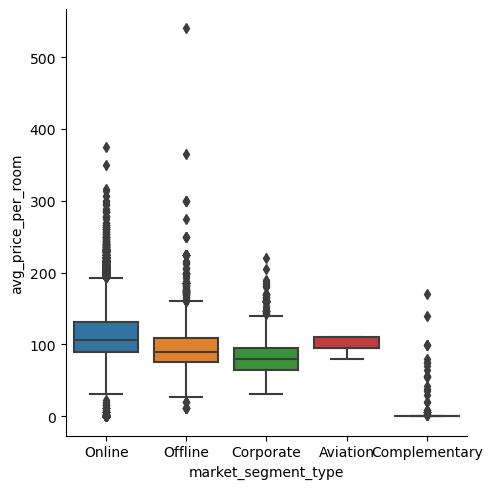

In [66]:
sns.catplot(data = df, x = 'market_segment_type', y = 'avg_price_per_room', kind = 'box')
plt.show()

In [67]:
df.groupby('market_segment_type')['avg_price_per_room'].median()

market_segment_type
Aviation          95.0
Complementary      0.0
Corporate         79.0
Offline           90.0
Online           106.2
Name: avg_price_per_room, dtype: float64

In [68]:
df['market_segment_type'].value_counts(normalize = True)

Online           0.655438
Offline          0.277767
Corporate        0.053094
Complementary    0.010338
Aviation         0.003363
Name: market_segment_type, dtype: float64

Complementary median price is 0 but there are some outliers for it. It may be an error in data recording or maybe its related to the additonal expenditure incurred by customers on complimentary ticked, or it may for discount. We need more information regarding this to make some inference on what is goinf on with this specific category.

Besides that Aviation customers dont have outliers and a smaller boxplot showing that they have been booked with some fixed price. From the boxplot we can see that the overall distribution of online is more wider and fluctuating that others. This is interesting data as people generally believe that Online customers pay less. And corporate has much smaller box with few outliers than Online and Offline indicating the Corporate discount users really pay less for the hotel booking overall.  

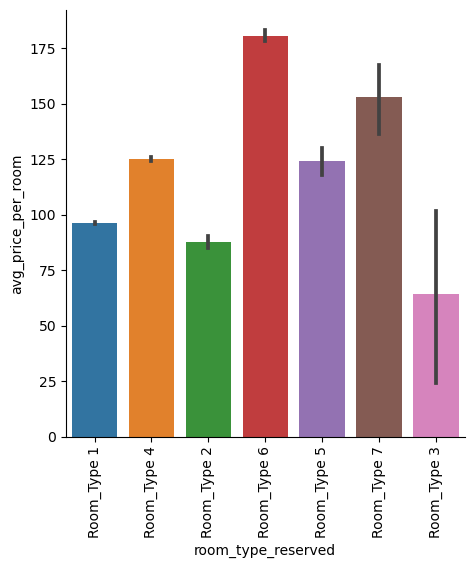

In [124]:
sns.catplot(data = df, x = 'room_type_reserved', y = 'avg_price_per_room', kind = 'bar')
plt.xticks(rotation = 90)
plt.show()

In [70]:
df['room_type_reserved'].value_counts(normalize = True)

Room_Type 1    0.783046
Room_Type 4    0.161296
Room_Type 6    0.025886
Room_Type 2    0.018305
Room_Type 5    0.007057
Room_Type 7    0.004245
Room_Type 3    0.000165
Name: room_type_reserved, dtype: float64

While we don't what are the specific room types, room type 6 has the highest average price with Room Type 1 having 3rd least price and having 78% proportion over total bookings.

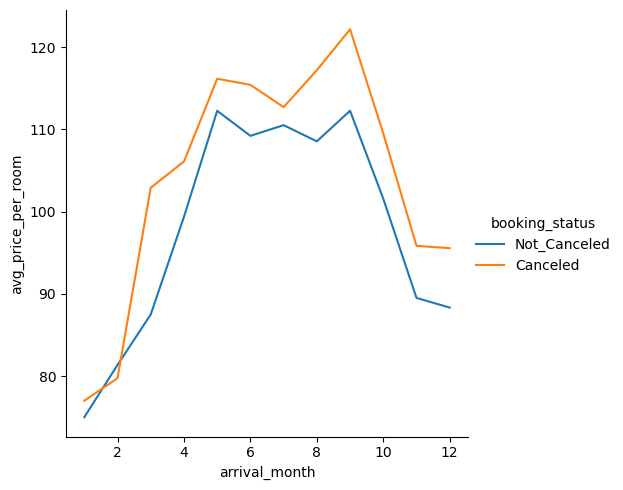

In [71]:
sns.relplot(data = df, x = 'arrival_month', y = 'avg_price_per_room', kind = 'line', ci = None, hue = 'booking_status')
plt.show()

From the above we can observe that trend of booking canceled and non canceled increase over months, bookings peak at the month of October.

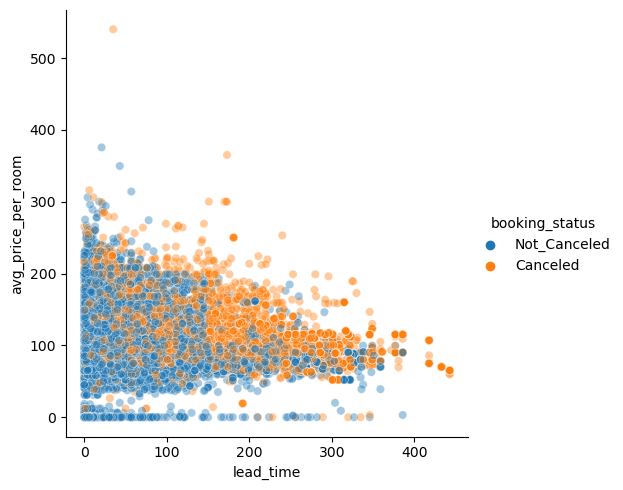

In [72]:
sns.relplot(data = df, x = 'lead_time', y = 'avg_price_per_room', kind = 'scatter', alpha = 0.4, hue = 'booking_status')
plt.show()

While there does not seem to any correlation between the lead time and average price per room when we divide it with the booking status we can see that most of the Canceled booking have high lead time of more than 200 and price of more than 100.

For other combinations we will run a pairplot below.

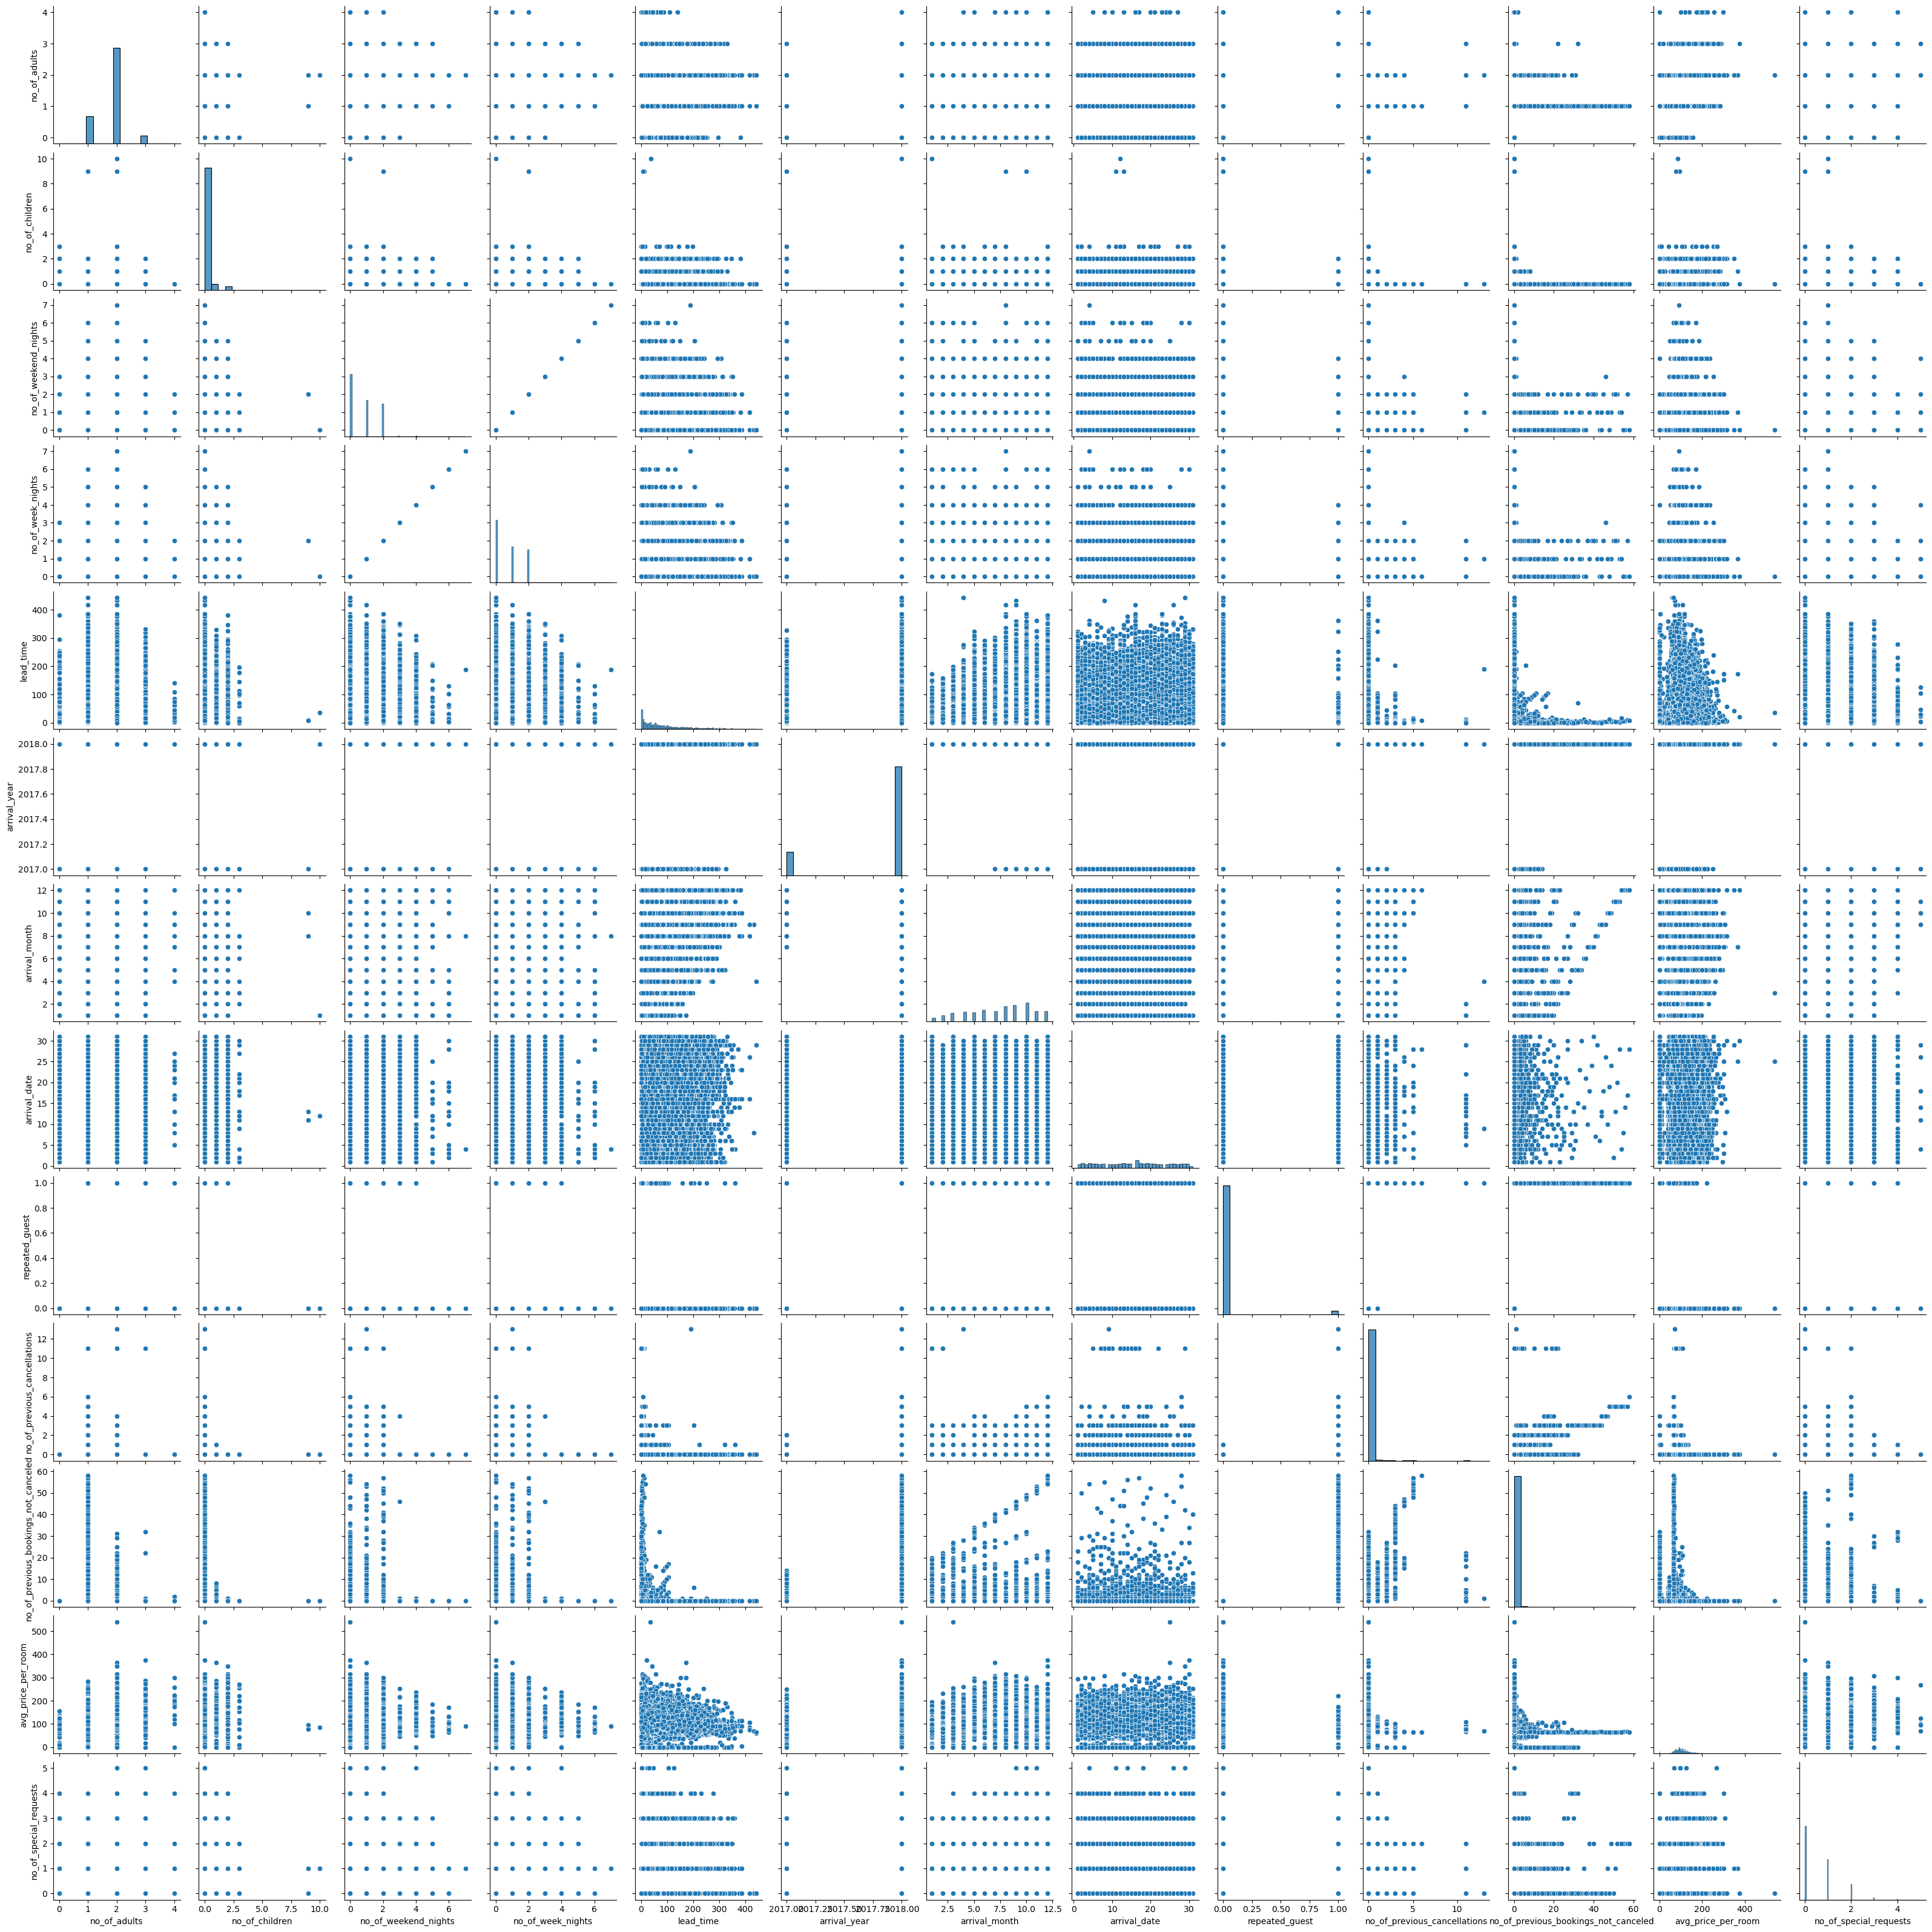

In [73]:
sns.pairplot(df)
plt.show()

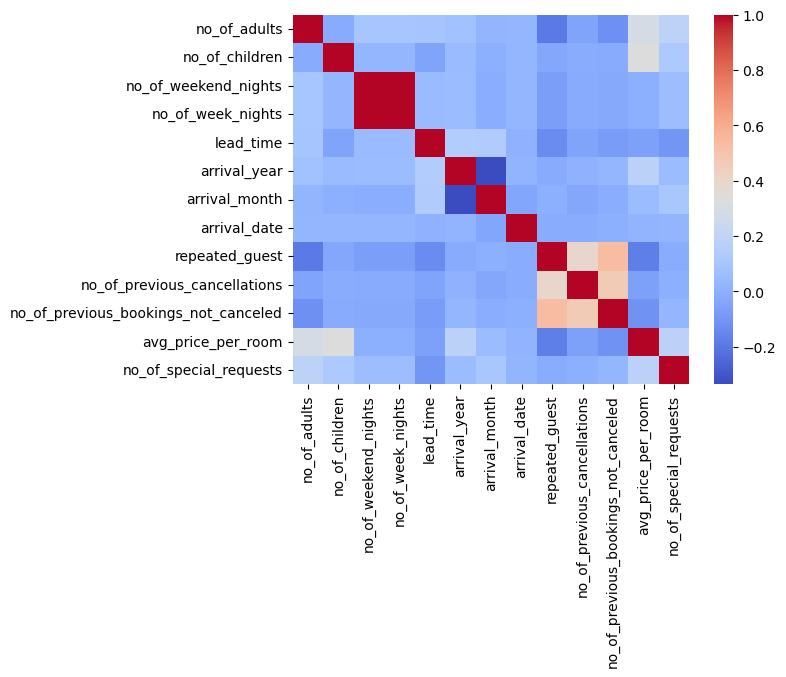

In [74]:
sns.heatmap(df.corr(), cmap = 'coolwarm')
plt.show()

From the pair plot and heat map we can see that correlation does exist between the avg_price_per_room and number of adults/children to some degrees and children and adults also being positively correlated signifying family travellers.

Beyond it we can find some correlations at 0.5 for the Repeated guest, No of previous cancellations, and no of previous bookings not cancelled. The correlation does not exceed 0.7 so we can't remove them on the basis of multi-collinearity. However if we get some input from industry expert we can further fine tune the data set by either removing some mildly correlated predictors and by imputing new predictors on the basis of existing one.

Now we are ready for the Modeling: Supervised and Unsupervised Learning.

## Models: Supervised Learning

We will cover following Supervised Learning Techniques in this part:
1. Logistic Regression
2. KNN
3. Random Forest
4. Adaboost
5. Multinomial Naive Bayes
6. Linear Support Vector Machine
7. Radial SVM

During the process we will try to optimize the hyper parameters with grid search, but a few codes for it has been commented because it takes a lot of time. It took me so long, more than 6 hours, to try for the parameters from the Grid Search for RBF SVM. Please use them with caution.

And for the model comparison we will record the time, test accuracy score, and F1 Score for each of the model and compare them in next part.

In [75]:
design_matrix = df.iloc[:,1:-1]

In [76]:
y_response = df.iloc[:,-1]

In [77]:
dummy_cols = [col for col in design_matrix.columns if (design_matrix[col].dtype == 'object'or design_matrix[col].dtype == 'Int64')]

In [78]:
dummy_cols

['no_of_adults',
 'no_of_children',
 'no_of_weekend_nights',
 'no_of_week_nights',
 'type_of_meal_plan',
 'room_type_reserved',
 'arrival_year',
 'arrival_month',
 'arrival_date',
 'market_segment_type',
 'repeated_guest',
 'no_of_previous_cancellations',
 'no_of_previous_bookings_not_canceled',
 'no_of_special_requests']

In [79]:
# We are creating dummy variables for Logistic regression and other models

design_matrix = pd.get_dummies(design_matrix, columns= dummy_cols, drop_first=True)

In [80]:
design_matrix.head()

,lead_time,avg_price_per_room,no_of_adults_1,no_of_adults_2,no_of_adults_3,no_of_adults_4,no_of_children_1,no_of_children_2,no_of_children_3,no_of_children_9,...,no_of_previous_bookings_not_canceled_54,no_of_previous_bookings_not_canceled_55,no_of_previous_bookings_not_canceled_56,no_of_previous_bookings_not_canceled_57,no_of_previous_bookings_not_canceled_58,no_of_special_requests_1,no_of_special_requests_2,no_of_special_requests_3,no_of_special_requests_4,no_of_special_requests_5
0,57.0,99.45,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,5.0,106.68,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,1.0,60.00,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,211.0,100.00,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,48.0,94.50,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [83]:
X_train, X_test, y_train, y_test = train_test_split(design_matrix, y_response, test_size = 0.2, random_state = 5)

In [84]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(29020, 152)
(29020,)
(7255, 152)
(7255,)


In [85]:
y_train = y_train.map({'Not_Canceled':0, 'Canceled':1})

In [86]:
y_test = y_test.map({'Not_Canceled':0, 'Canceled':1})

In [87]:
y_test.head()

14044    0
13826    0
26267    0
26006    0
24306    0
Name: booking_status, dtype: int64

In [97]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression as LR
import time as time
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering

### Logistic Regression

In [88]:
scores = dict()
time_taken = dict()
f1 = dict()

In [89]:
#liblinear works best with this dataset. We can further optimize the predictors and reduce them but since
#we are using model for predictions only we are more concerned about the predictive ability, not the inferential power.

t0 = time.time()
lr_model = LR(solver = 'liblinear').fit(X_train, y_train)
t1 = time.time()
print(t1 - t0)
time_taken['Linear Regression'] = t1 - t0

0.30886387825012207


In [90]:
print('Logistic Regression Score', lr_model.score(X_test, y_test))
scores['Logistic Regression:'] = lr_model.score(X_test, y_test)
f1['Logistic Regression'] = f1_score(y_test, lr_model.predict(X_test))

Logistic Regression Score 0.8048242591316334


### KNN

In [91]:
#For KNN grid search gave best parameter to be 1 for highest score
t_0 = time.time()
knn_model = KNN(n_neighbors = 1).fit(X_train, y_train)
t_1 = time.time()
print(t1 - t0)
time_taken['Linear knn_model'] = t1 - t0

0.30886387825012207


In [92]:
print('KNN Score:',knn_model.score(X_test, y_test))
scores['KNN'] = knn_model.score(X_test, y_test)
f1['KNN'] = f1_score(y_test, knn_model.predict(X_test))

C:\Users\91956\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


KNN Score: 0.8053756030323914


C:\Users\91956\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\91956\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

### Random Forest

In [109]:
#This grid search will take a lot of time to comple, please proceed with caution. Best parameters will be
#N estimators 100, min sample leaf = 1, max_depth will be 36, and max features will be sqrt function

# paras_rf = {'n_estimators':[10,20,30,40,50,100,200], 'min_samples_leaf' : [1,2,3,5,8,10,15], 'max_features': ['sqrt', 'log2'], 'max_depth':[5,10,15,20,30,35,36,37,38,39,40]}
# grid = GridSearchCV(RandomForestClassifier(), paras_rf).fit(X_train, y_train)
# grid.best_params_

In [93]:
t0 = time.time()
rf_model = RandomForestClassifier(n_estimators = 100, max_features = 'sqrt', max_depth = 36,random_state = 10).fit(X_train, y_train)
t1 = time.time()
print('Random Forest Score', rf_model.score(X_test, y_test))
time_taken['Random Forest'] = t1 - t0
scores['Random Forest'] = rf_model.score(X_test, y_test)
f1['Random Forest'] = f1_score(y_test, rf_model.predict(X_test))

Random Forest Score 0.8868366643694005


### AdaBoost

In [151]:
#For adaboost it is taking even more time. A single Adaboost model with 300 stumps is taking 32 seconds to run

 paras_ada = {'n_estimators': [50,100,200,300],'learning_rate': [0.1,0.2,0.5,1,1.5,1.7,1.8,1.9,2.0,2.1,2.5]}
grid = GridSearchCV(AdaBoostClassifier(), paras_ada).fit(X_train, y_train)
grid.best_params_

In [153]:
t0 = time.time()
ada_model = AdaBoostClassifier(n_estimators=300, learning_rate = 1.7, random_state = 110).fit(X_train, y_train)
t1 = time.time()
print('Adaboost Score', ada_model.score(X_test, y_test))
time_taken['Adaboost'] = t1 - t0
scores['Adaboost'] = ada_model.score(X_test, y_test)
f1['Adaboost'] = f1_score(y_test, ada_model.predict(X_test))

Adaboost Score 0.8227429359062716


### Multinomial Naive Bayes

In [94]:
t0 = time.time()
naive_multimonial_model = MultinomialNB().fit(X_train, y_train)
t1 = time.time()

print('Multinomial Naive Bayes Score', naive_multimonial_model.score(X_test, y_test))
time_taken['Multinomial Naive Bayes'] = t1 - t0
scores['Multinomial Naive Bayes'] = naive_multimonial_model.score(X_test, y_test)
f1['Multinomial Naive Bayes'] = f1_score(y_test, naive_multimonial_model.predict(X_test))

Multinomial Naive Bayes Score 0.6981392143349414


### Linear SVM

In [95]:
#Linear SVM not working properly besides default with this dataset

t0 = time.time()
linear_svm_model = LinearSVC(random_state = 110).fit(X_train, y_train)
t1 = time.time()

print('Linear SVM Score', linear_svm_model.score(X_test, y_test))
time_taken['Linear SVM'] = t1 - t0
scores['Linear SVM'] = linear_svm_model.score(X_test, y_test)
f1['Linear SVM'] = f1_score(y_test, linear_svm_model.predict(X_test))

Linear SVM Score 0.7404548587181254


C:\Users\91956\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


### RBF SVM

In [159]:
#We can tune the parameters for the SVC with the given formula. It should be run with caution. On my machine
#I was forced to terminate it after 7 hours of running. With better CPU and faster RAM/SSD it may be processed faster

# parameters = {'C':[0.5,1,5, 8, 10, 16, 32,36,40], 'gamma':[1,2,4,8,10,16,18,20,24,32]}
# grid = GridSearchCV(SVC(random_state = 110), parameters, cv = 5).fit(X_train, y_train)

In [108]:
t0 = time.time()
rbf_svm_model = SVC(random_state = 110).fit(X_train, y_train)
t1 = time.time()

print('Radial SVM Score', linear_svm_model.score(X_test, y_test))
time_taken['Radial SVM'] = t1 - t0
scores['Radial SVM'] = linear_svm_model.score(X_test, y_test)
f1['Radial SVM'] = f1_score(y_test, linear_svm_model.predict(X_test))

Radial SVM Score 0.7404548587181254


## Unsupervised Learning

For the Unsupervised Learning we are using K Means Clustering and Hierarchical/Agglomerative Clustering as we have 2 given clusters and at such a small number of groups NMF and other Unsupervised learning will be making only more complex models, not better ones. 

### K-Means Clustering

In [128]:
#We are using k means as the sole hyper parameter to run the algorithm faster and also because besides it we can only choose
#n_clusters which we know about, there are only 2 clusters here.

t0 = time.time()
kmeans_model = KMeans(n_clusters=2, random_state=0, init = 'k-means++').fit(X_train)
t1 = time.time()
labels, acc = label_permute_compare(y_test, kmeans_model.predict(X_test))

print('KMeans Score', acc)
time_taken['KMeans'] = t1 - t0
scores['KMeans'] = acc
f1['KMeans'] = f1_score(y_test, kmeans_model.predict(X_test))

KMeans Score 0.7455547898001378


### Agglomerative Clustering

In [101]:
#This may take time please run it with caution

# for linkage in ['ward', 'complete', 'average', 'single']:
#     for affinity in ['euclidean', 'l1', 'l2', 'manhattan', 'cosine']:
#         acc=0
#         try:
#             model = AgglomerativeClustering(n_clusters = 2, linkage = linkage, affinity = affinity).fit(X_train)
#             labelorder, acc = label_permute_compare(y_test, model.fit_predict(X_test))
#             print(linkage, affinity, labelorder, acc)    
#         except:    
#             print(f'Combo of {linkage} and {affinity} is not allowed')
# print('')

ward euclidean (1, 0) 0.6764989662301861
Combo of ward and l1 is not allowed
Combo of ward and l2 is not allowed
Combo of ward and manhattan is not allowed
Combo of ward and cosine is not allowed
complete euclidean (0, 1) 0.6835286009648518
complete l1 (0, 1) 0.6662991040661612
complete l2 (0, 1) 0.6835286009648518
complete manhattan (0, 1) 0.6662991040661612
complete cosine (0, 1) 0.6864231564438319
average euclidean (0, 1) 0.6833907649896623
average l1 (1, 0) 0.6833907649896623
average l2 (0, 1) 0.6833907649896623
average manhattan (1, 0) 0.6833907649896623
average cosine (1, 0) 0.6799448656099242
single euclidean (0, 1) 0.6835286009648518
single l1 (0, 1) 0.6835286009648518
single l2 (0, 1) 0.6835286009648518
single manhattan (0, 1) 0.6835286009648518
single cosine (0, 1) 0.6832529290144728



In [123]:
#Taking best hyper parameters based on Grid Search

t0 = time.time()
agg_model = AgglomerativeClustering(n_clusters = 2, linkage = 'complete', affinity = 'euclidean').fit(X_train)
t1 = time.time()
labels, acc = label_permute_compare(y_test, agg_model.fit_predict(X_test))

print('Agg Score', acc)
time_taken['Agg'] = t1 - t0
scores['Agg'] = acc
f1['Agg'] = f1_score(y_test, agg_model.fit_predict(X_test))

Agg Score 0.6835286009648518


In [121]:
scores

{'Logistic Regression:': 0.8048242591316334,
 'KNN': 0.8053756030323914,
 'Random Forest': 0.8868366643694005,
 'Multinomial Naive Bayes': 0.6981392143349414,
 'Linear SVM': 0.7404548587181254,
 'Radial SVM': 0.7404548587181254,
 'KMeans': 0.6835286009648518,
 'Agg': 0.6835286009648518}

In [122]:
f1

{'Logistic Regression': 0.6711565257779842,
 'KNN': 0.7055879899916597,
 'Random Forest': 0.8125998630449669,
 'Multinomial Naive Bayes': 0.5609462710505212,
 'Linear SVM': 0.5794058521331249,
 'Radial SVM': 0.5794058521331249,
 'KMeans': 0.0008703220191470844,
 'Agg': 0.0008703220191470844}

### Model Result Comparison

Now we have created various models, both Supervised and Unsupervised, while optimizing their Hyperparameters for the Hotel Cancellation Dataset. We are now equipped to suggest the model which will be most useful to use the user.

In [ ]:
To analyse the result in a tabular form we will create a full DataFrame with Models, Scores(Accuracy), Time, and F1 Scores.

In [129]:
result_df = pd.DataFrame({'Models': scores.keys(), 'Scores':scores.values(), 'Time':time_taken.values(), 'F1':f1.values()})

In [130]:
result_df

,Models,Scores,Time,F1
0,Logistic Regression:,0.804824,0.308864,0.671157
1,KNN,0.805376,0.308864,0.705588
2,Random Forest,0.886837,6.828200,0.812600
3,Multinomial Naive Bayes,0.698139,0.035001,0.560946
4,Linear SVM,0.740455,4.037295,0.579406
5,Radial SVM,0.740455,123.503412,0.579406
6,KMeans,0.745555,0.507573,0.305559
7,Agg,0.683529,200.725852,0.000870


In [131]:
result_df.sort_values('Scores', ascending = False)

,Models,Scores,Time,F1
2,Random Forest,0.886837,6.828200,0.812600
1,KNN,0.805376,0.308864,0.705588
0,Logistic Regression:,0.804824,0.308864,0.671157
6,KMeans,0.745555,0.507573,0.305559
4,Linear SVM,0.740455,4.037295,0.579406
5,Radial SVM,0.740455,123.503412,0.579406
3,Multinomial Naive Bayes,0.698139,0.035001,0.560946
7,Agg,0.683529,200.725852,0.000870


Random Forest has the highest Accuracy/F1 Score. We ill sugges it to the hotel as it is simple and faster to implement.

Overall Supervised Learning Methods worked better for this problem. While 